In [1]:
# %%bash
# pip install scikeras

## If it doesn't run, need to switch to scikitlearn 1.5.1 (pip install scikit-learn==1.5.1)
## From scikitlearn 1.6 onwards, this code is not compatible due to changes in Keras wrapper

In [2]:
import pandas as pd
import numpy as np
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.utils import class_weight
from _functions import (
    custom_classification_report,
    get_max_fscore_i, 
    plot_PR_curve,
    plot_PR_threshold_curve,
    plot_confusion_matrix, 
    plot_loss, 
    plot_learning_rate
)

In [3]:
tf.random.set_seed(42)

plt.ioff()

In [4]:
############################
##### Define Functions #####
############################

def build_model(layer_sizes, learning_rate, input_dim):
    model = models.Sequential([layers.Input(shape=(input_dim,))])
    for size in layer_sizes:
        model.add(layers.Dense(size, activation="relu"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [5]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [6]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']
y_col = ['fraudulent']

df2 = df[X_numeric_cols + X_text_cols + X_cat_cols + y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col].values.ravel()  # Convert to 1D array

In [7]:
##############################
##### Data preprocessing #####
##############################

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to TF-IDF features so that the neural network can process them
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Combine numeric and text features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")

Training shape: (14426, 9497)
Test shape: (3607, 9497)


In [8]:
#######################################################################
#### Define model architectures and hyperparameters, and variables ####
#######################################################################

# different architectures to compare
architectures = {
    "Shallow": [32],
    "Medium": [64, 32],
    "Deep": [128, 64, 32],
    "Deeper": [128, 64, 32, 16],
    "Wide": [256, 128],
    "Wider": [512, 128],
    "Deeper and Wider":[512, 256, 128, 32]
}

learning_rates = [
    # 0.003,
    0.001,
    # 0.0003
]

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights: ", class_weights)

# dictionary to store evaluation results, histories, trained models, and plots
results = {}
histories = {}
trained_models = {}
plots = {}
best_thresholds ={}

# final conversion to float32 for TensorFlow compatibility
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

Class weights:  {0: np.float64(0.5391687845716848), 1: np.float64(6.88263358778626)}



Training Shallow...

Training Shallow (Fold 1)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Shallow (Fold 2)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training Shallow (Fold 3)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Shallow (Fold 4)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training Shallow (Fold 5)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Shallow (Fold 6)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training Shallow (Fold 7)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Shallow (Fold 8)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Shallow (Fold 9)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Shallow (Fold 10)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

d:\data\YSH\data\2025 Senior Fall\CMSC 327 - Machine Learning\Final project\CMSC327_project\_functions.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
           precision    recall  f1-score  f2-score   support

Not Fraud       0.99      0.97      0.98      0.98      1328
    Fraud       0.74      0.93      0.83      0.89       115

 accuracy                                     0.97      1443


Training Medium...

Training Medium (Fold 1)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 2)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 3)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 4)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 5)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 6)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training Medium (Fold 7)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 8)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 9)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Medium (Fold 10)...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━

<Figure size 600x400 with 0 Axes>

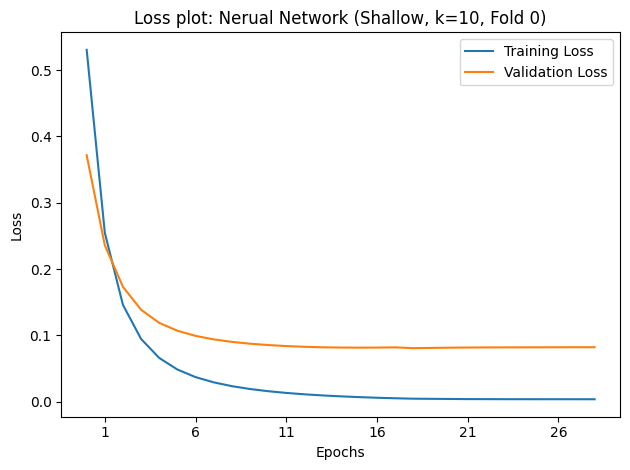

<Figure size 600x400 with 0 Axes>

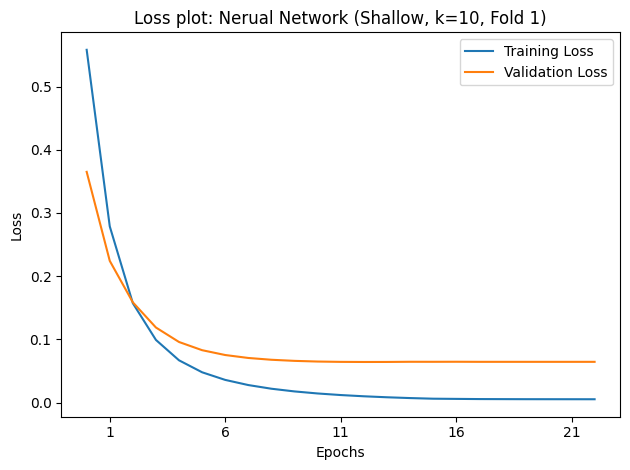

<Figure size 600x400 with 0 Axes>

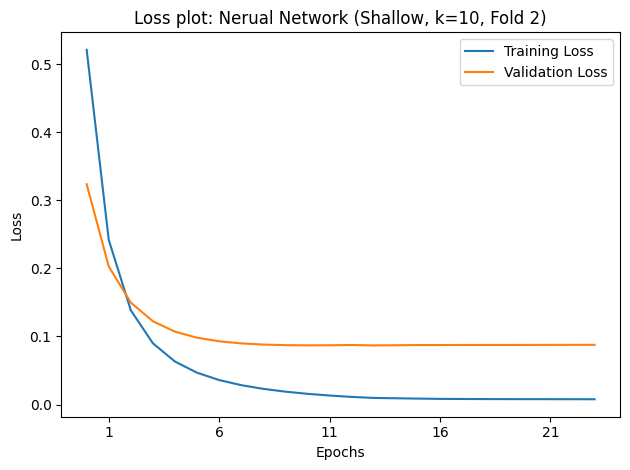

<Figure size 600x400 with 0 Axes>

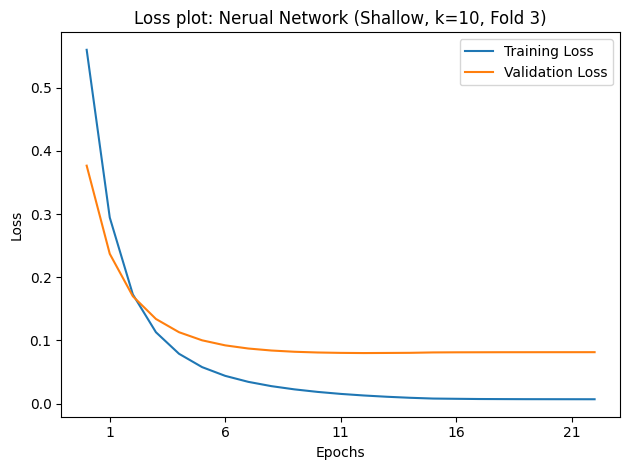

<Figure size 600x400 with 0 Axes>

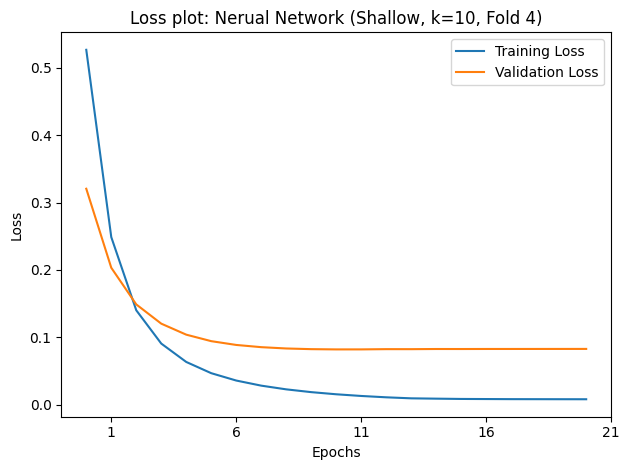

<Figure size 600x400 with 0 Axes>

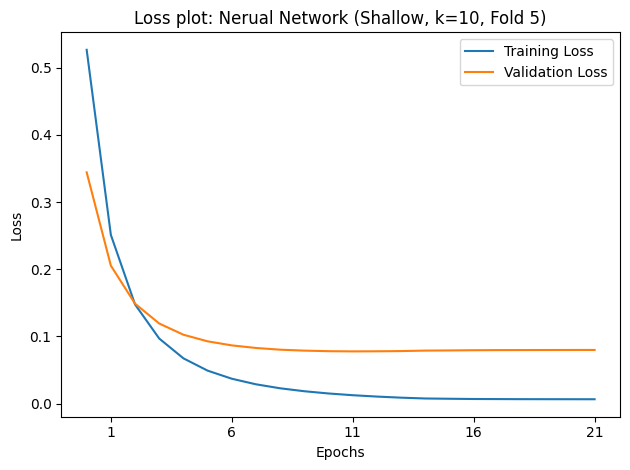

<Figure size 600x400 with 0 Axes>

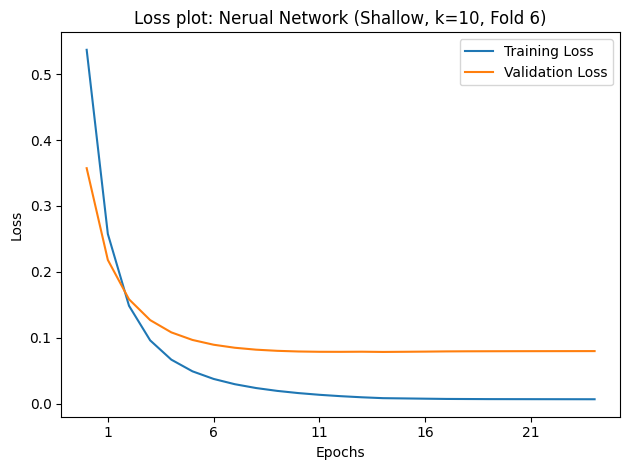

<Figure size 600x400 with 0 Axes>

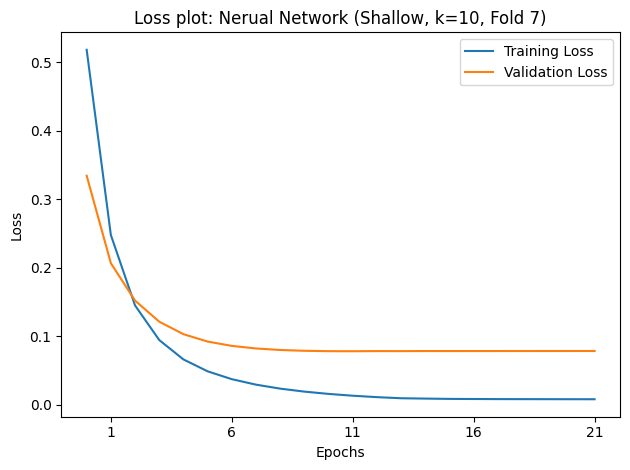

<Figure size 600x400 with 0 Axes>

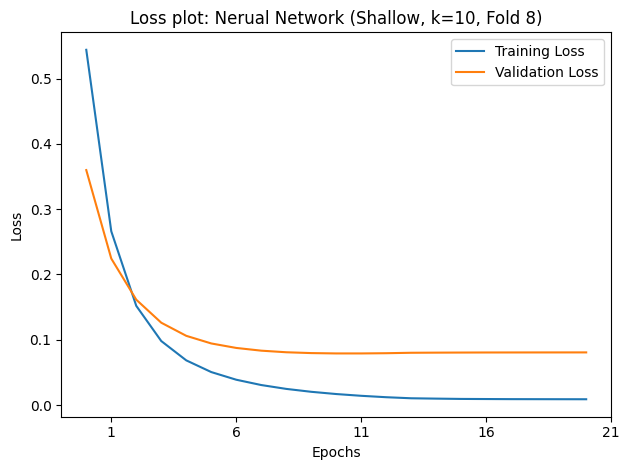

<Figure size 600x400 with 0 Axes>

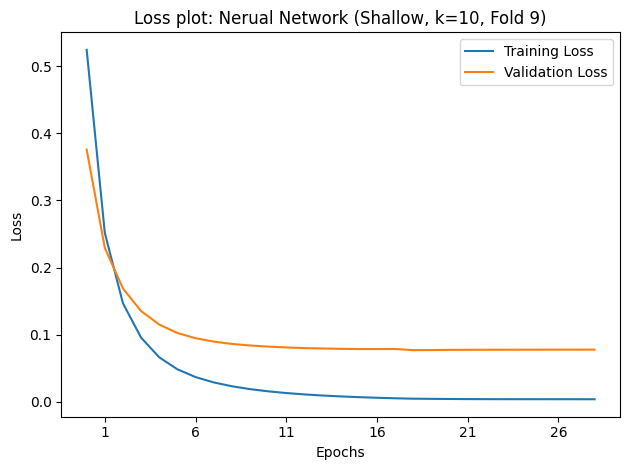

<Figure size 600x400 with 0 Axes>

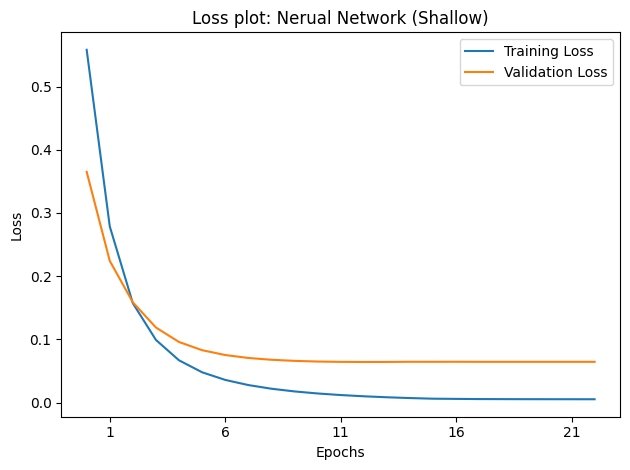

<Figure size 600x400 with 0 Axes>

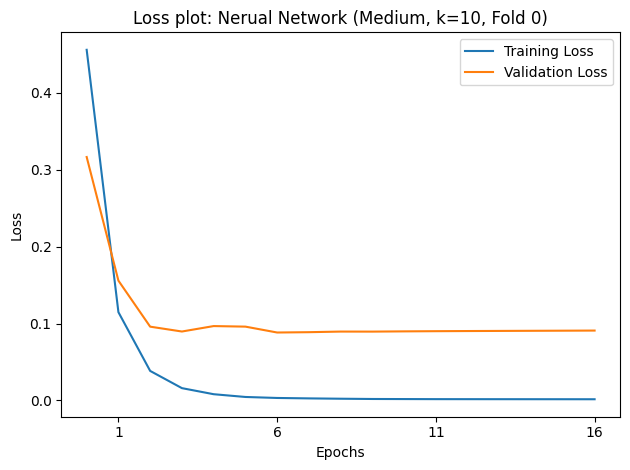

<Figure size 600x400 with 0 Axes>

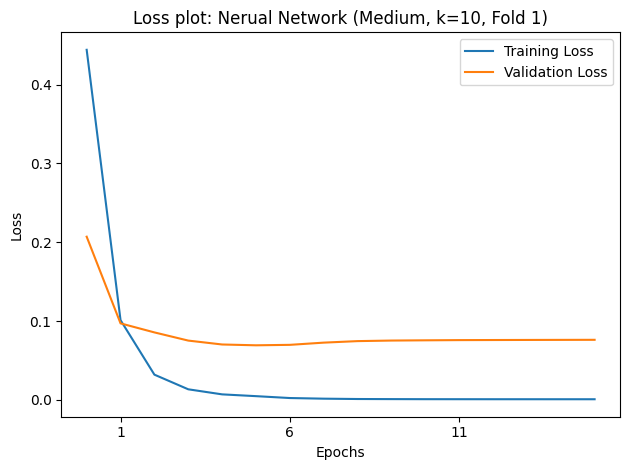

<Figure size 600x400 with 0 Axes>

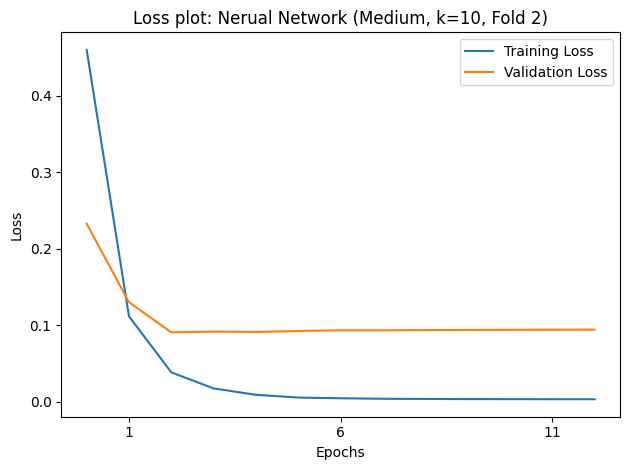

<Figure size 600x400 with 0 Axes>

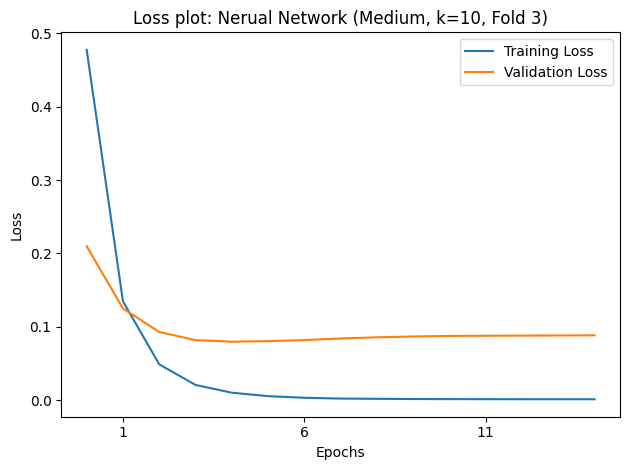

<Figure size 600x400 with 0 Axes>

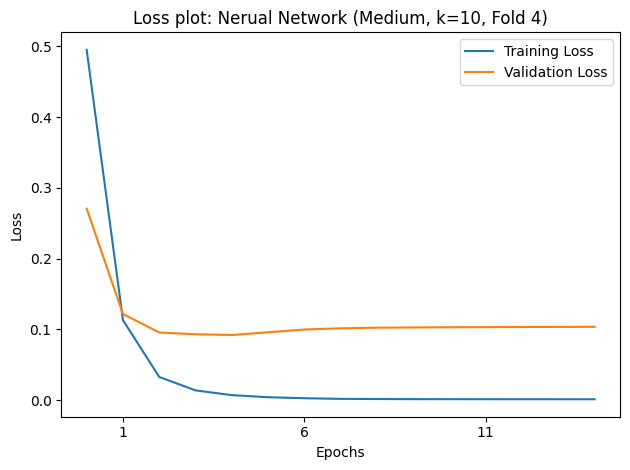

<Figure size 600x400 with 0 Axes>

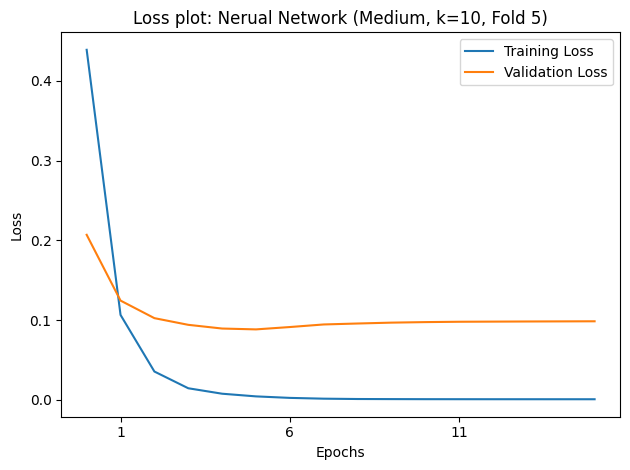

<Figure size 600x400 with 0 Axes>

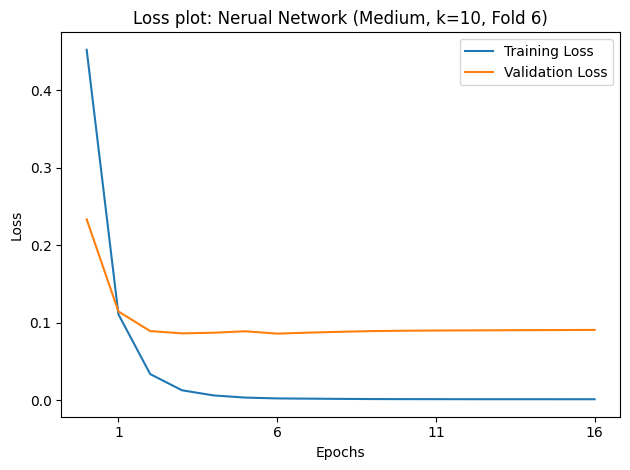

<Figure size 600x400 with 0 Axes>

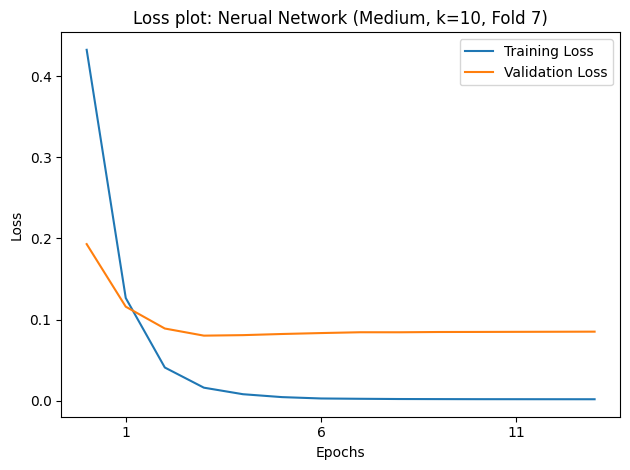

<Figure size 600x400 with 0 Axes>

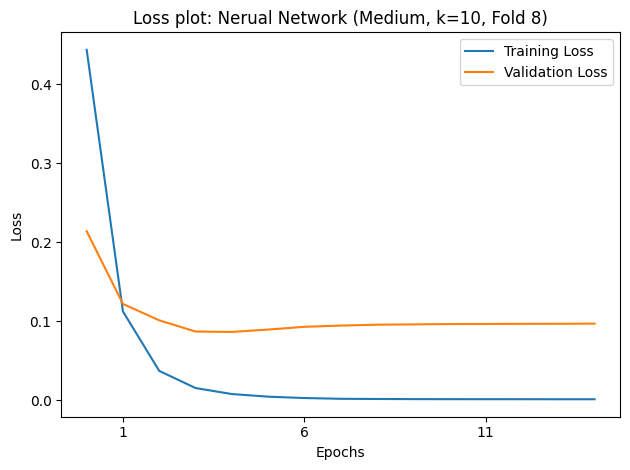

<Figure size 600x400 with 0 Axes>

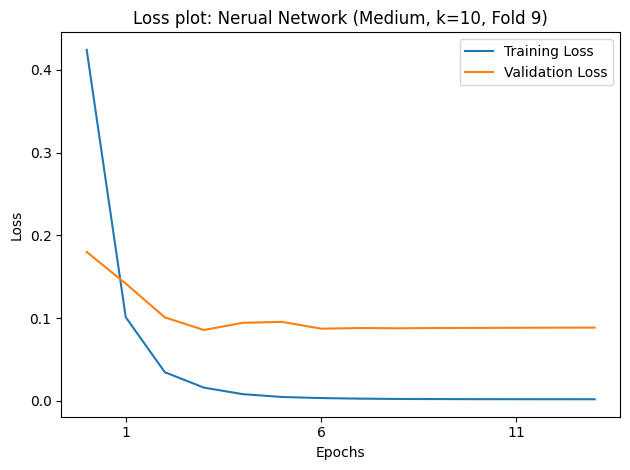

<Figure size 600x400 with 0 Axes>

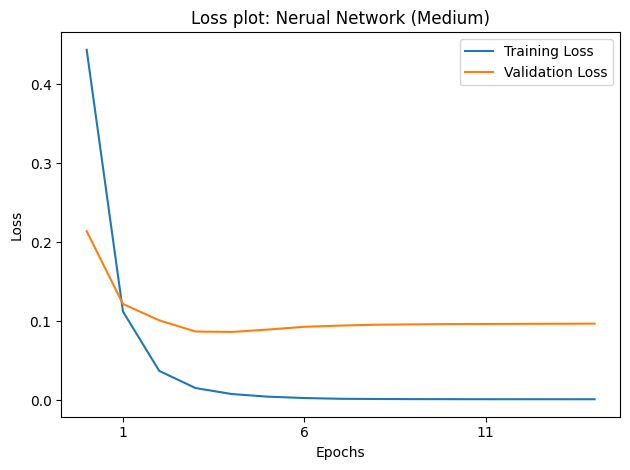

<Figure size 600x400 with 0 Axes>

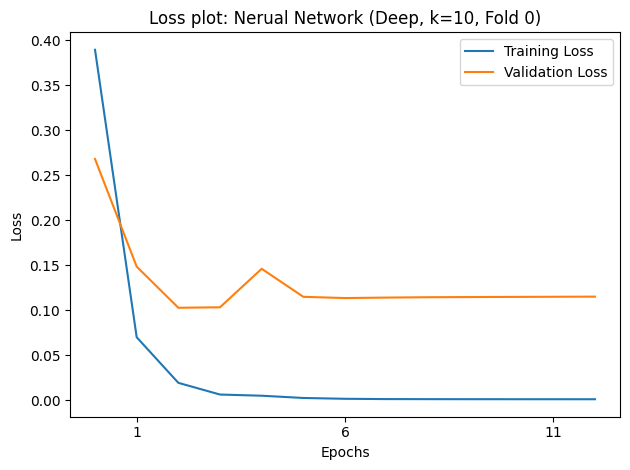

<Figure size 600x400 with 0 Axes>

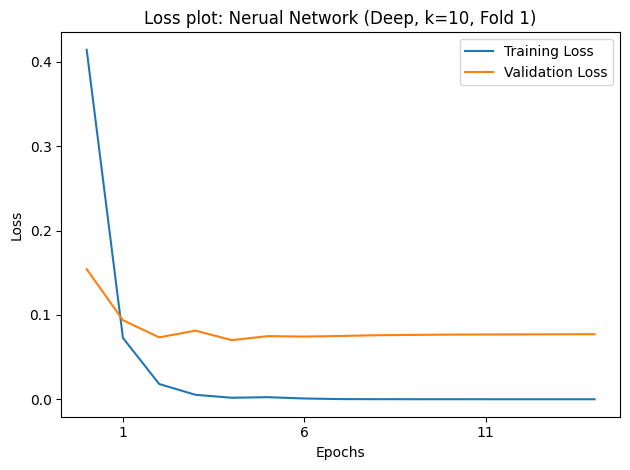

<Figure size 600x400 with 0 Axes>

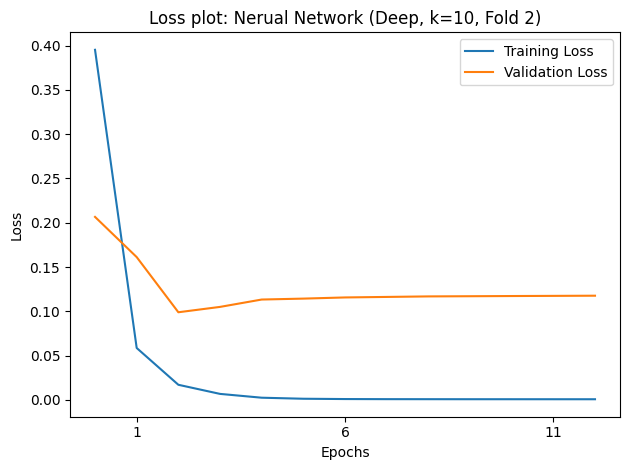

<Figure size 600x400 with 0 Axes>

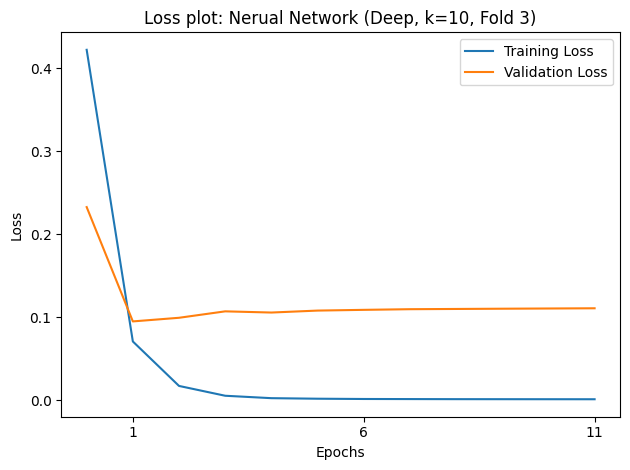

<Figure size 600x400 with 0 Axes>

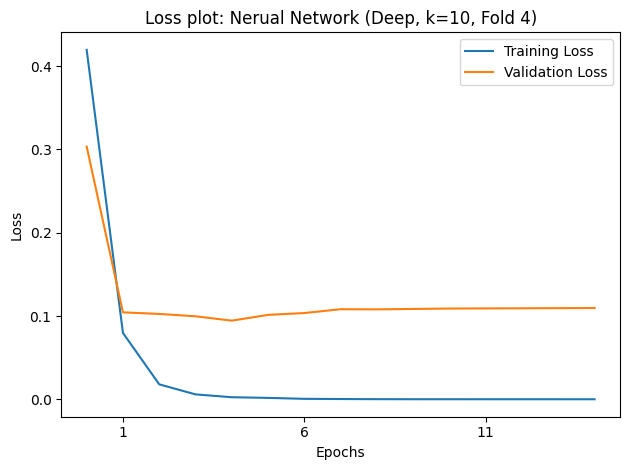

<Figure size 600x400 with 0 Axes>

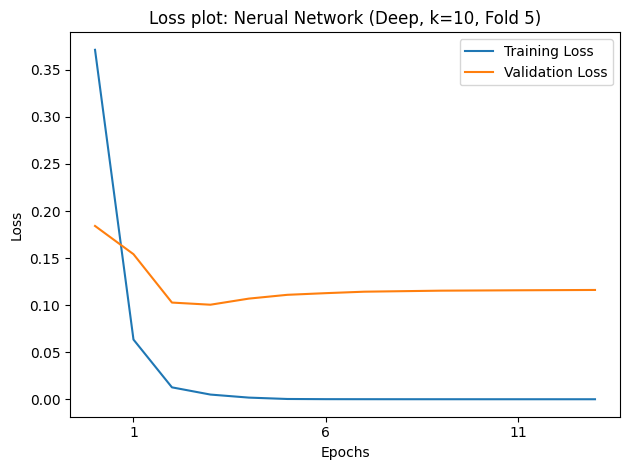

<Figure size 600x400 with 0 Axes>

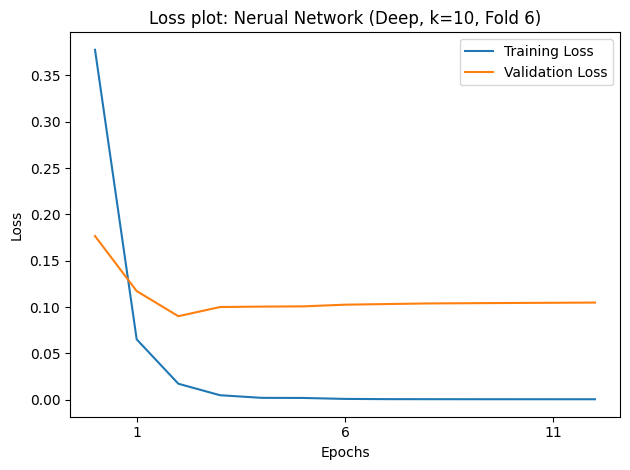

<Figure size 600x400 with 0 Axes>

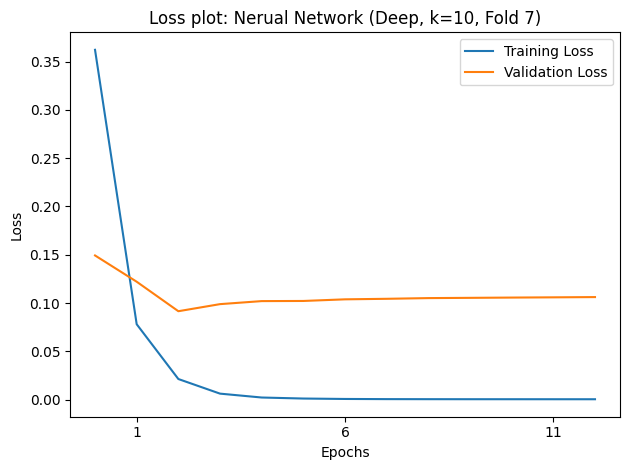

<Figure size 600x400 with 0 Axes>

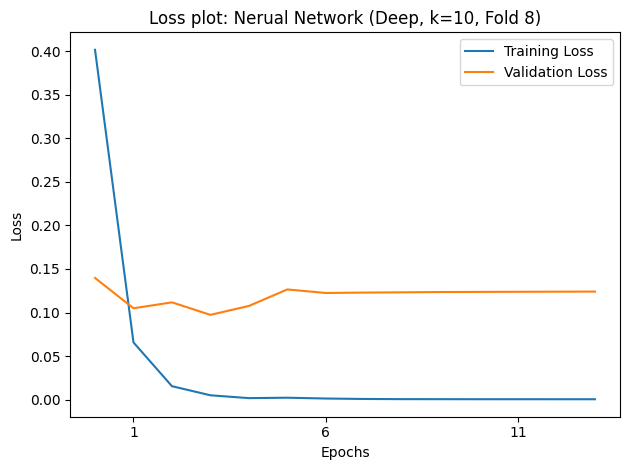

<Figure size 600x400 with 0 Axes>

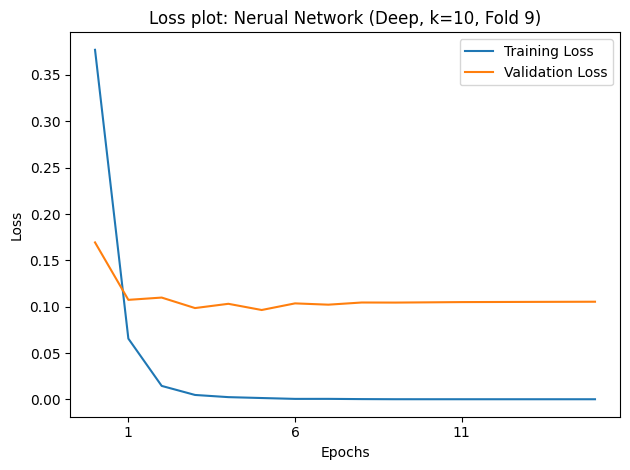

<Figure size 600x400 with 0 Axes>

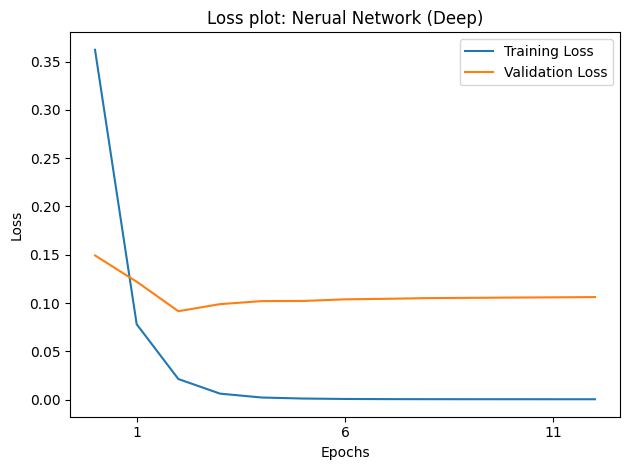

<Figure size 600x400 with 0 Axes>

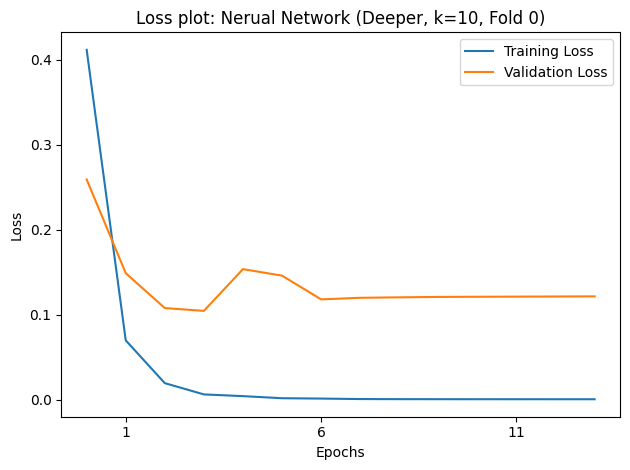

<Figure size 600x400 with 0 Axes>

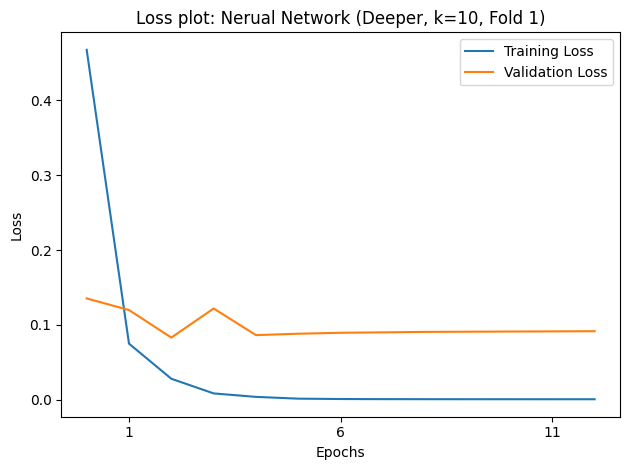

<Figure size 600x400 with 0 Axes>

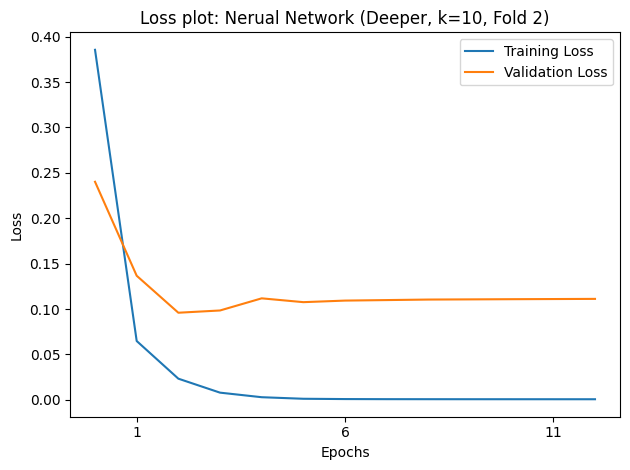

<Figure size 600x400 with 0 Axes>

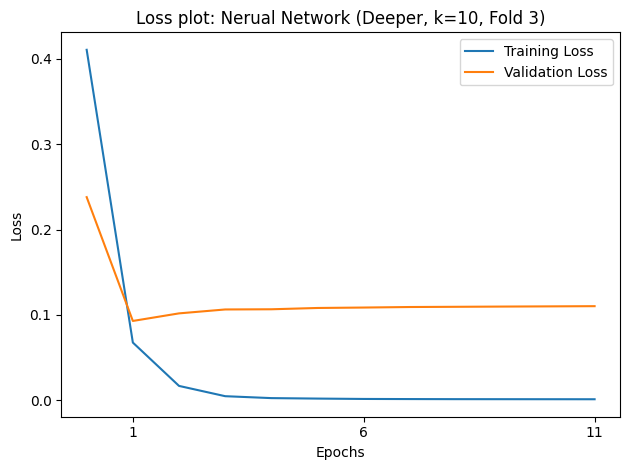

<Figure size 600x400 with 0 Axes>

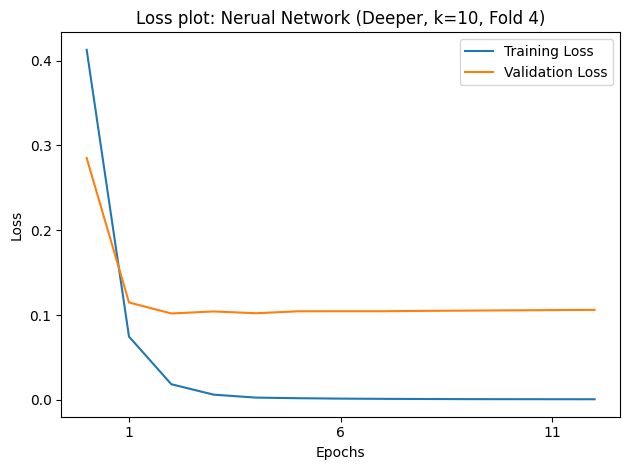

<Figure size 600x400 with 0 Axes>

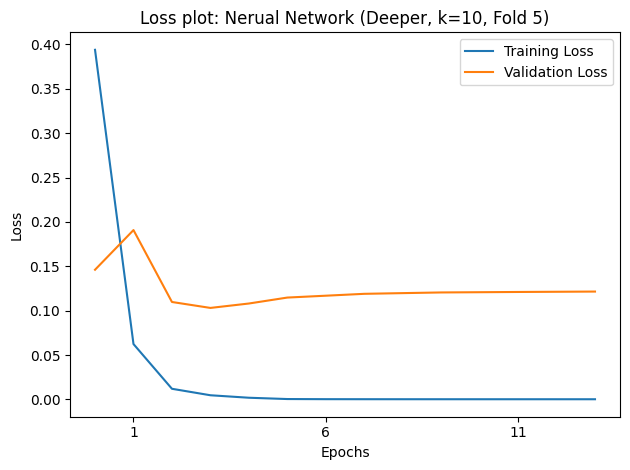

<Figure size 600x400 with 0 Axes>

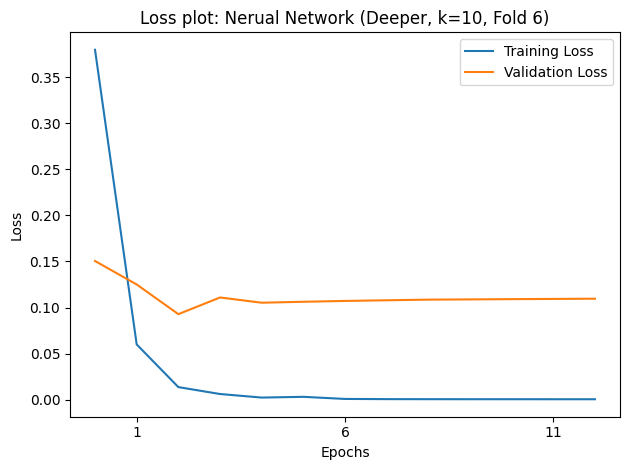

<Figure size 600x400 with 0 Axes>

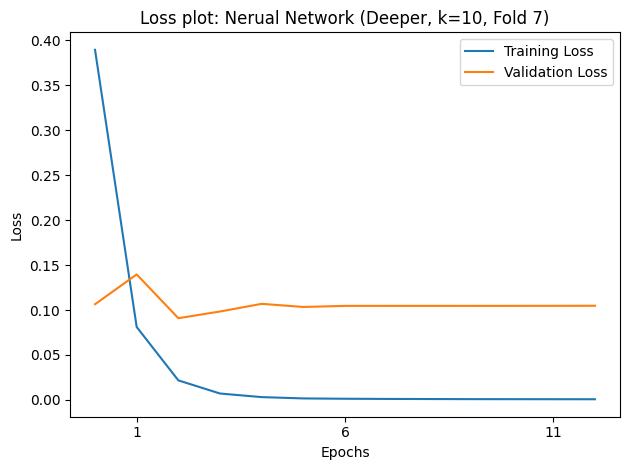

<Figure size 600x400 with 0 Axes>

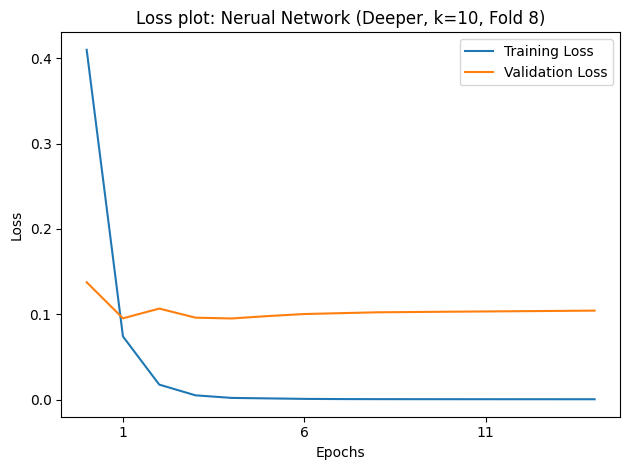

<Figure size 600x400 with 0 Axes>

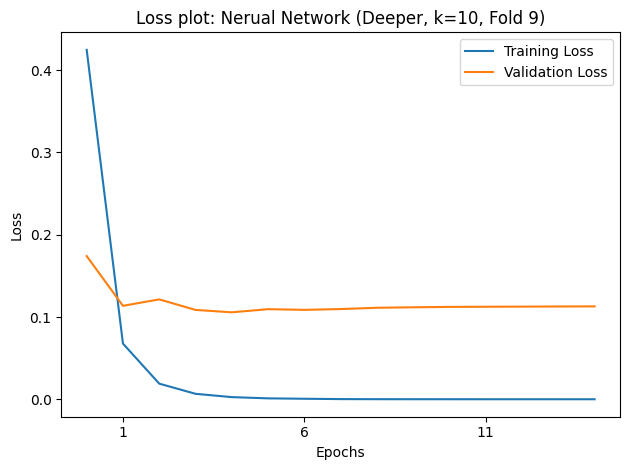

<Figure size 600x400 with 0 Axes>

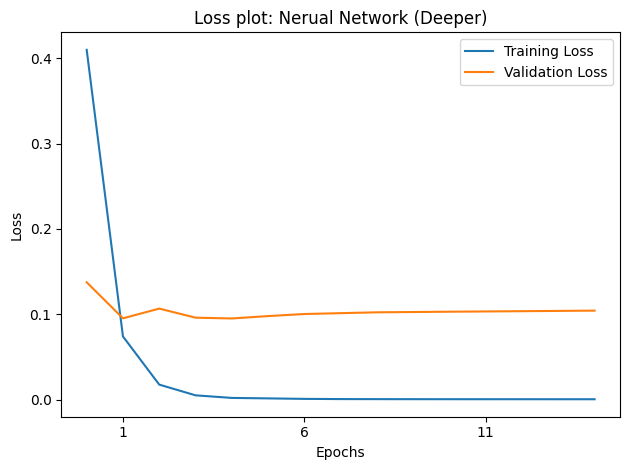

<Figure size 600x400 with 0 Axes>

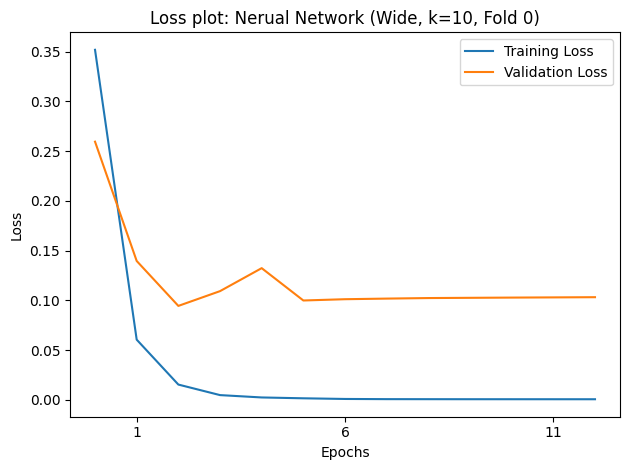

<Figure size 600x400 with 0 Axes>

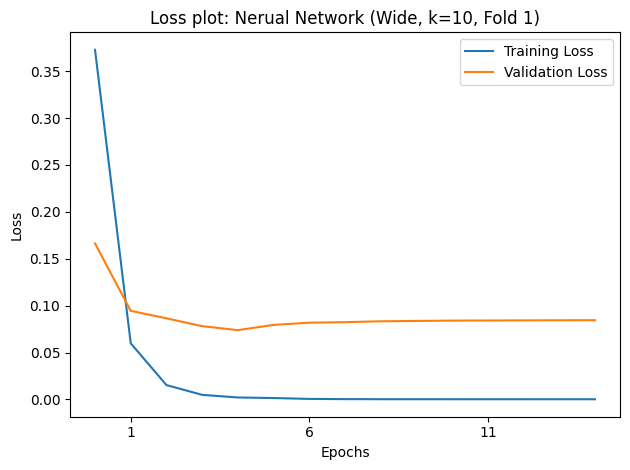

<Figure size 600x400 with 0 Axes>

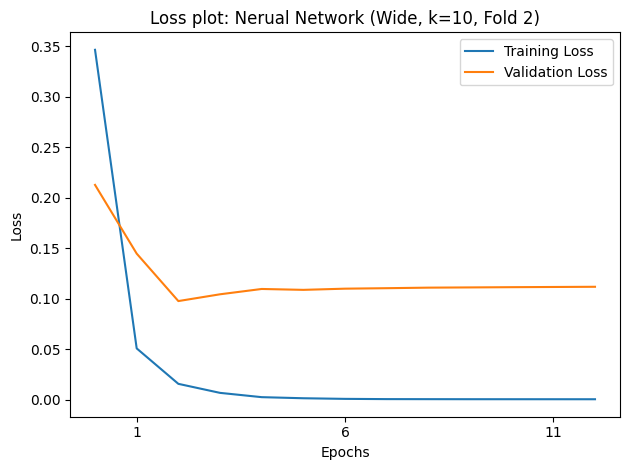

<Figure size 600x400 with 0 Axes>

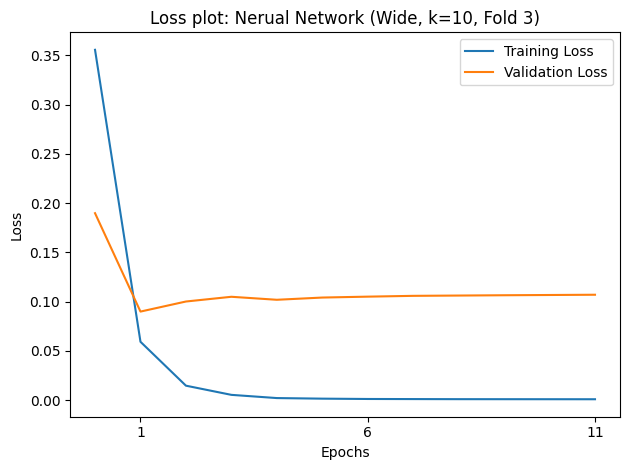

<Figure size 600x400 with 0 Axes>

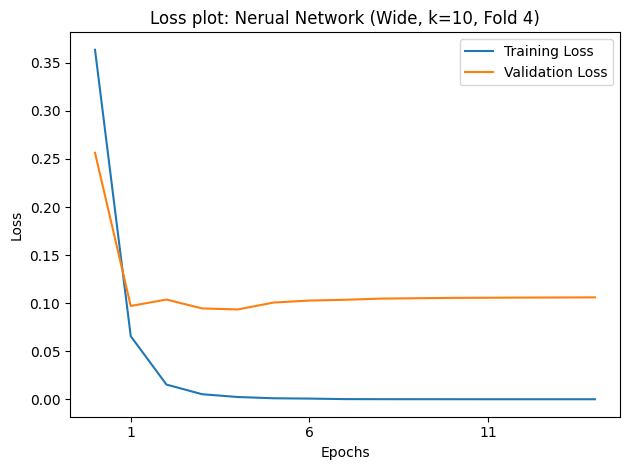

<Figure size 600x400 with 0 Axes>

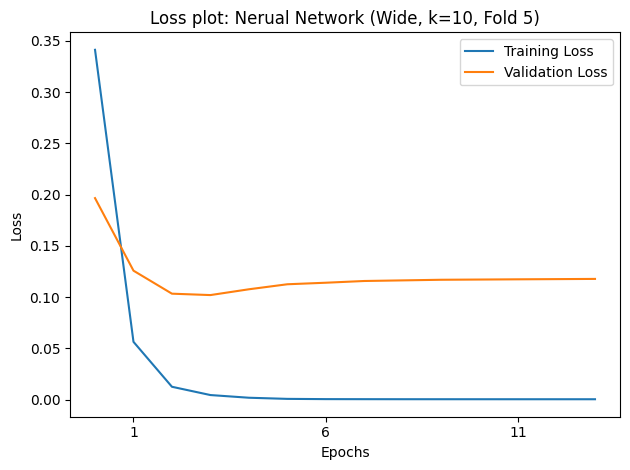

<Figure size 600x400 with 0 Axes>

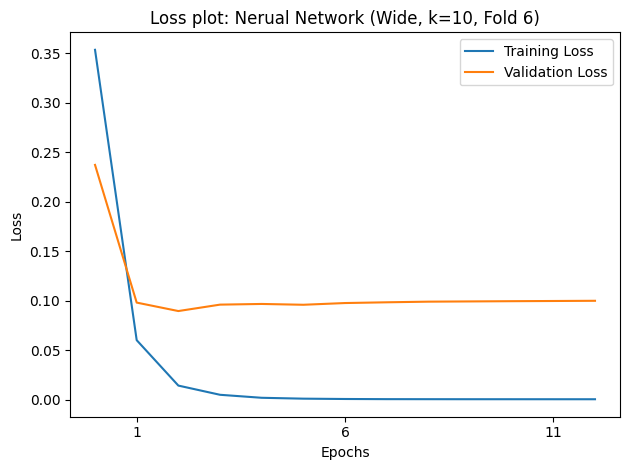

<Figure size 600x400 with 0 Axes>

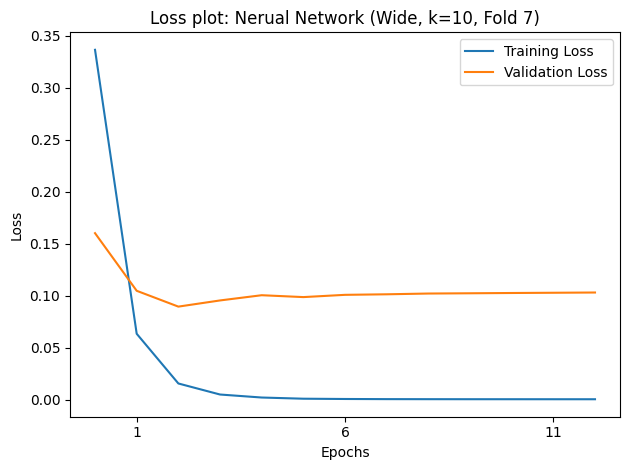

<Figure size 600x400 with 0 Axes>

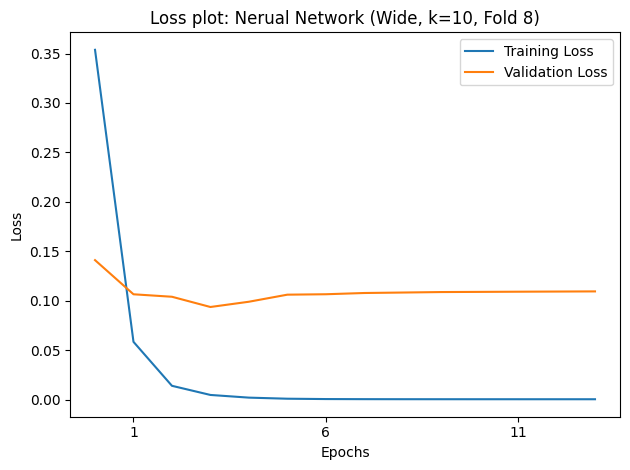

<Figure size 600x400 with 0 Axes>

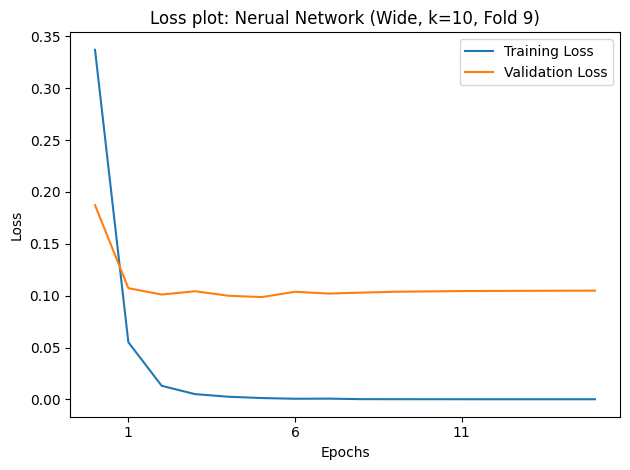

<Figure size 600x400 with 0 Axes>

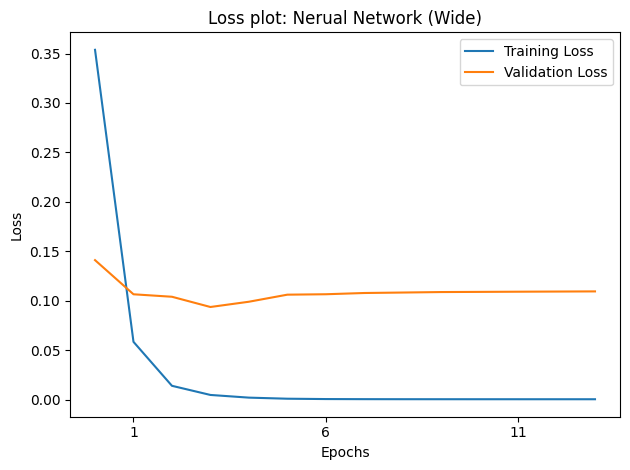

<Figure size 600x400 with 0 Axes>

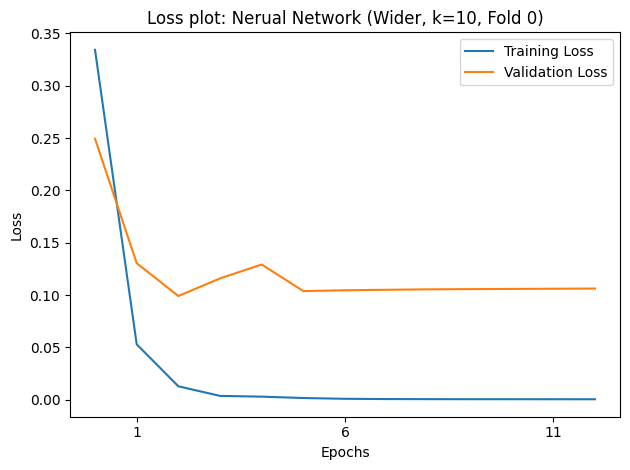

<Figure size 600x400 with 0 Axes>

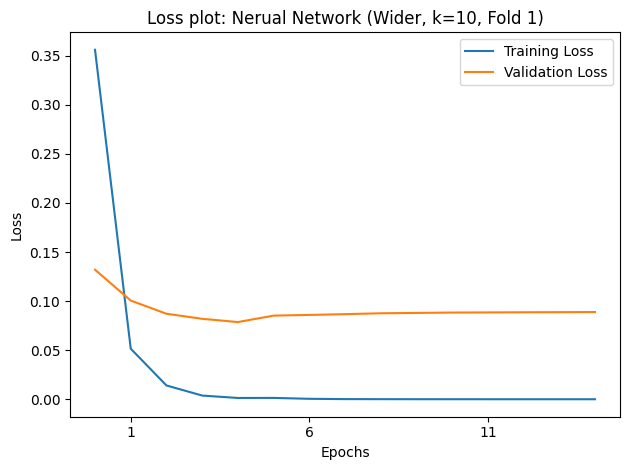

<Figure size 600x400 with 0 Axes>

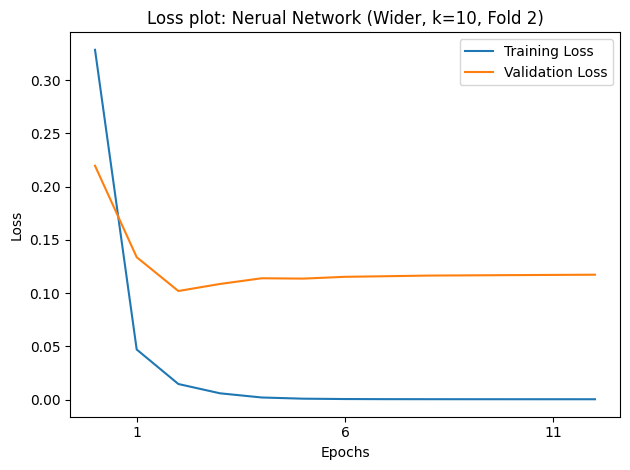

<Figure size 600x400 with 0 Axes>

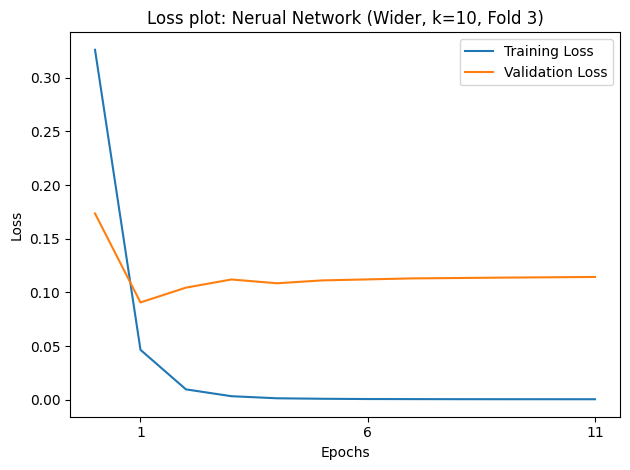

<Figure size 600x400 with 0 Axes>

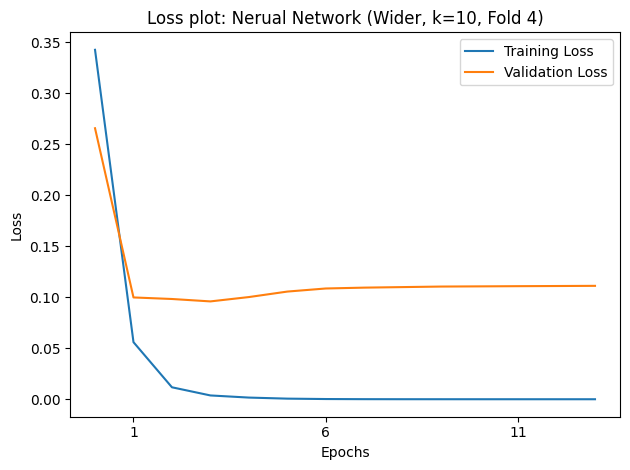

<Figure size 600x400 with 0 Axes>

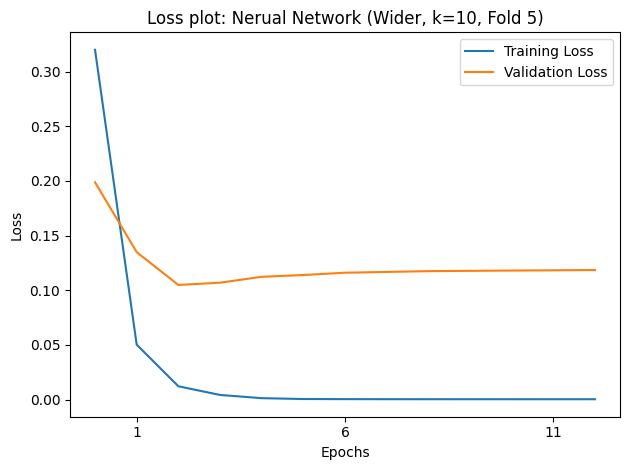

<Figure size 600x400 with 0 Axes>

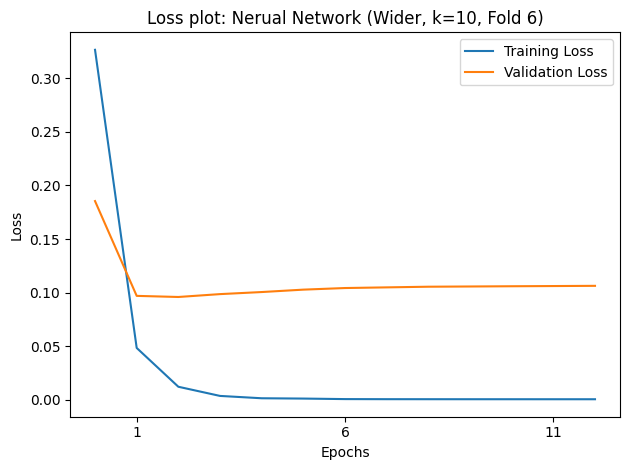

<Figure size 600x400 with 0 Axes>

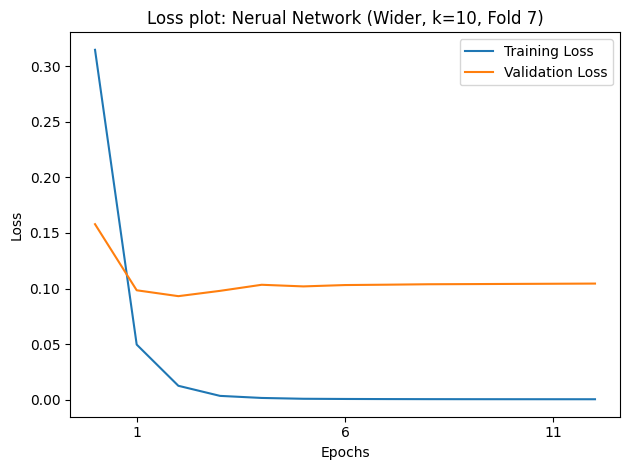

<Figure size 600x400 with 0 Axes>

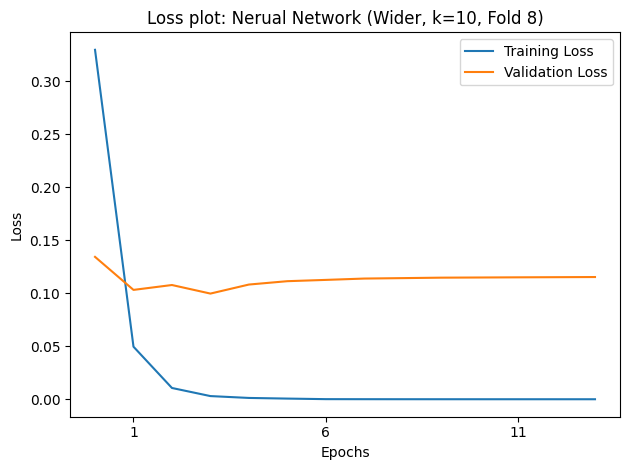

<Figure size 600x400 with 0 Axes>

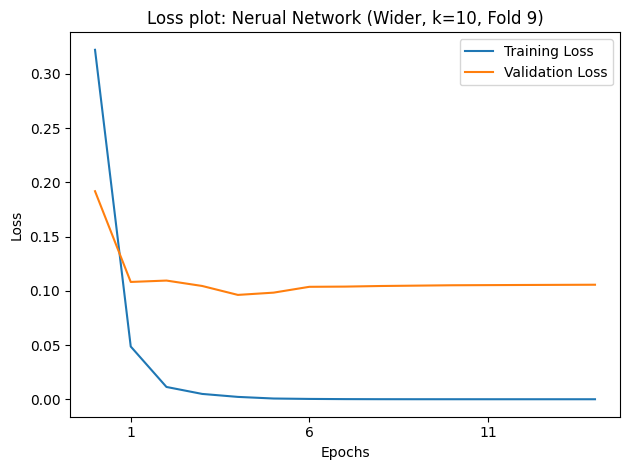

<Figure size 600x400 with 0 Axes>

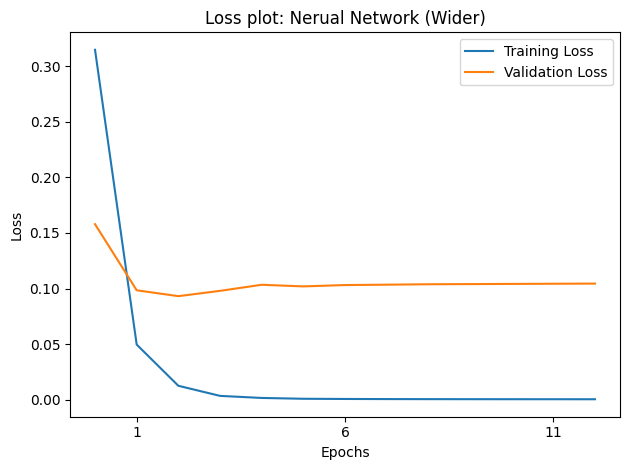

<Figure size 600x400 with 0 Axes>

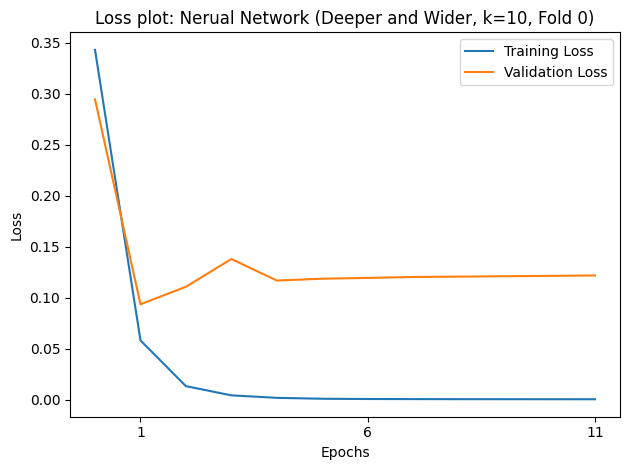

<Figure size 600x400 with 0 Axes>

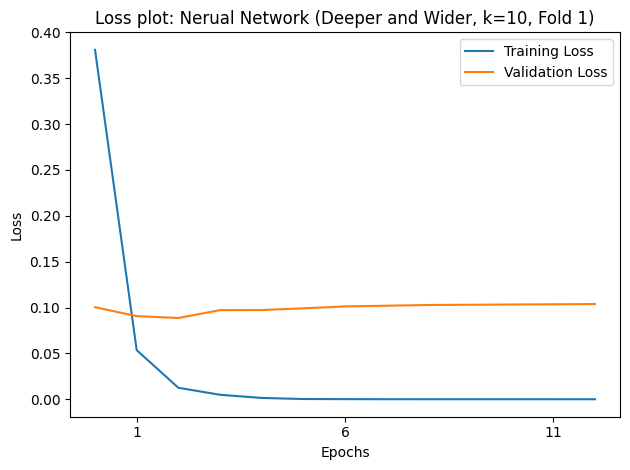

<Figure size 600x400 with 0 Axes>

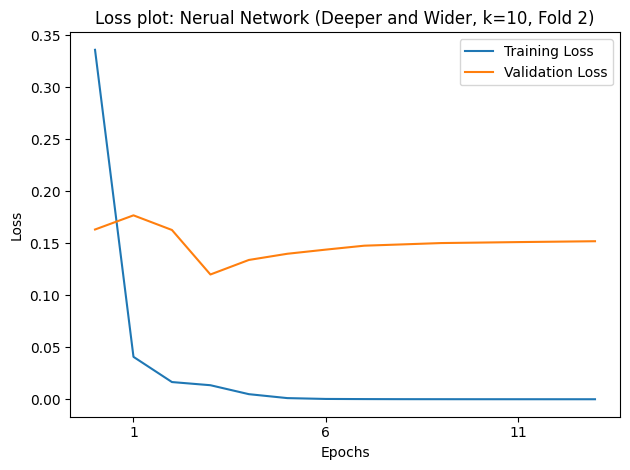

<Figure size 600x400 with 0 Axes>

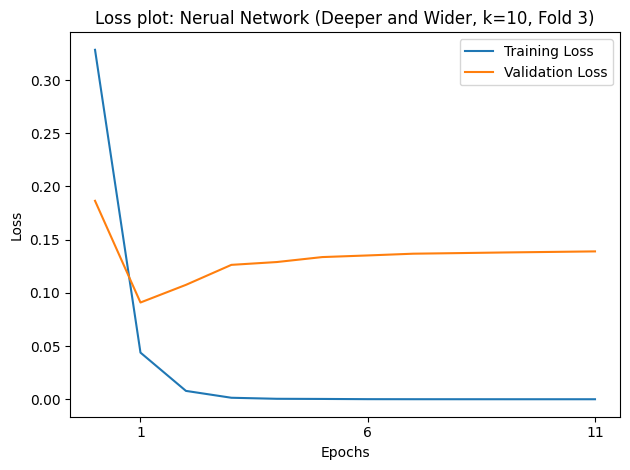

<Figure size 600x400 with 0 Axes>

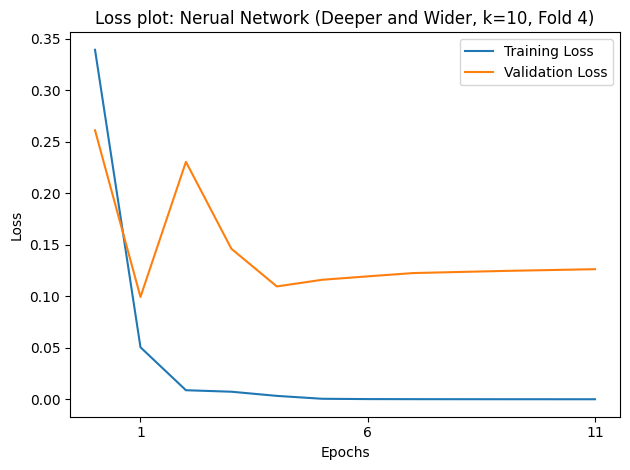

<Figure size 600x400 with 0 Axes>

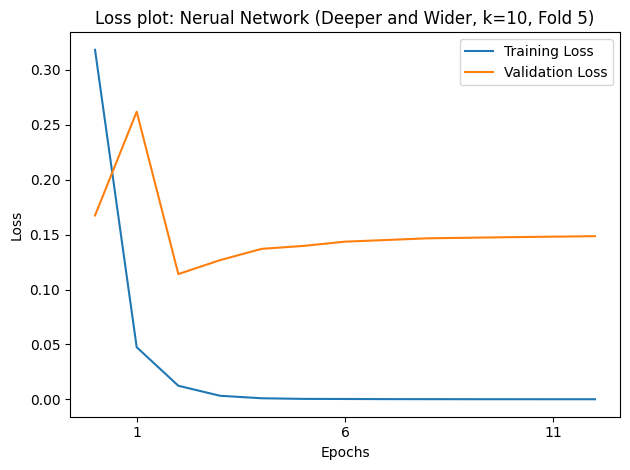

<Figure size 600x400 with 0 Axes>

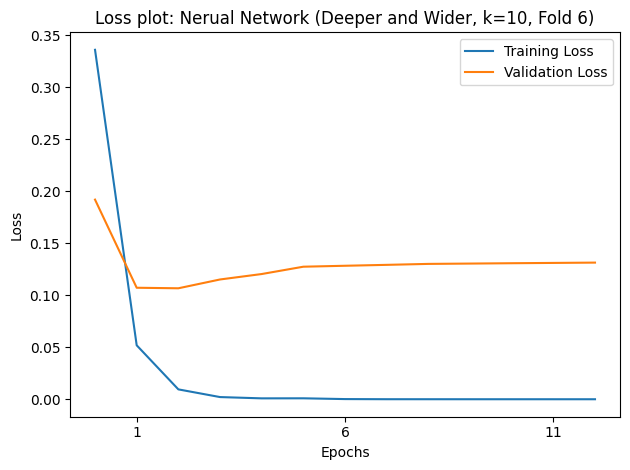

<Figure size 600x400 with 0 Axes>

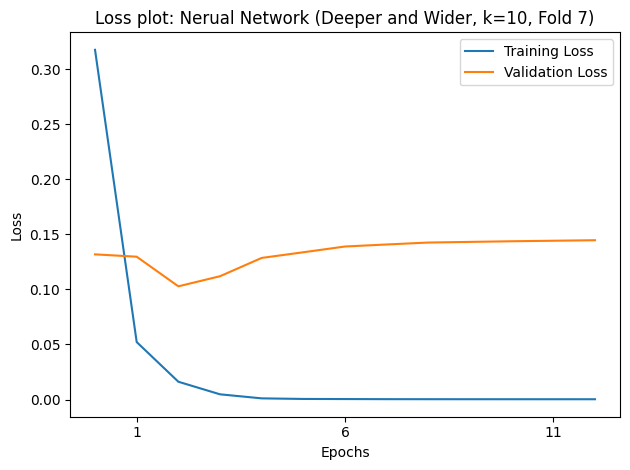

<Figure size 600x400 with 0 Axes>

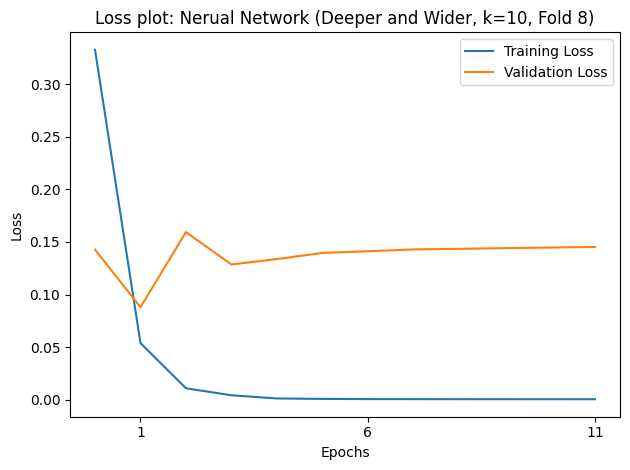

<Figure size 600x400 with 0 Axes>

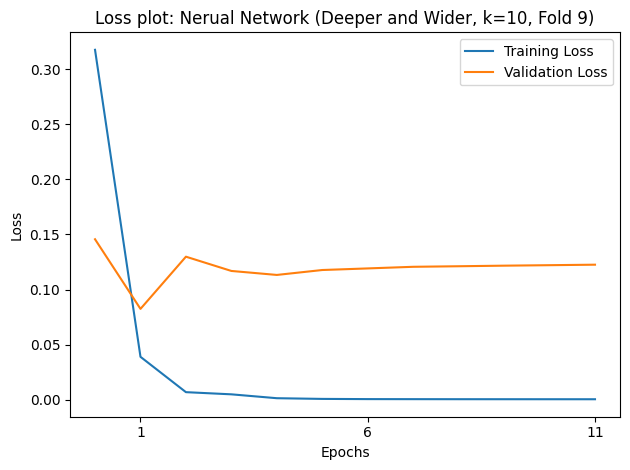

<Figure size 600x400 with 0 Axes>

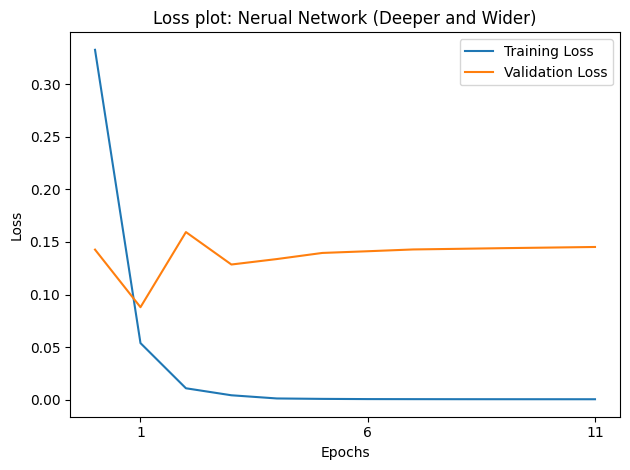

In [9]:
####################################################
#### Train and evaluate each model architecture ####
####################################################

k = 10
kF = KFold(n_splits=k, shuffle=True, random_state=42)

for (layer_name, layer_sizes), learning_rate in product(architectures.items(), learning_rates):
    name = layer_name
    print(f"\nTraining {name}...")
    
    results_folds = []
    histories_folds = []
    trained_models_folds = []
    plots_folds = []
    thresholds_folds = []

    for fold, (train_i, val_i) in enumerate(kF.split(X_train_processed)):
        print(f"\nTraining {name} (Fold {fold+1})...")
        
        X_train_processed_fold, X_val_processed_fold = X_train_processed[train_i], X_train_processed[val_i]
        y_train_fold, y_val_fold = y_train[train_i], y_train[val_i]
        
        model = build_model(layer_sizes, learning_rate, X_train_processed_fold.shape[1])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs to tolerate
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=0.00003)
        model_history = model.fit(X_train_processed_fold, y_train_fold, validation_split=0.2, 
                            epochs=300, batch_size=128,                 # we need a big batch size as our dataset is imbalanced with minority class of 5%
                            class_weight=class_weights,                 # class_weights also address for the imbalance
                            callbacks=[early_stopping, reduce_lr],      # reduce_lr reduces the learning rate when the val_loss does not change signifiantly
                            verbose=0) 
        
        # make probability predictions
        y_pred_proba = model.predict(X_val_processed_fold).flatten()
        
        # compute the best threshold
        precision, recall, thresholds = precision_recall_curve(y_val_fold, y_pred_proba)
        max_f2_i = get_max_fscore_i(precision, recall, beta=2.0)
        best_threshold = thresholds[max_f2_i]

        # Make predictions based on the best threshold
        y_pred = (y_pred_proba >= best_threshold).astype(int)

        # compute the metrics
        f2 = ((1+2**2) * precision[max_f2_i] * recall[max_f2_i]) / ((2**2 * precision[max_f2_i]) + recall[max_f2_i])
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision[max_f2_i]
        recall = recall[max_f2_i]

        # store results
        results_folds.append({"F2": f2, "Accuracy": accuracy, "Precision": precision, "Recall": recall})      # store the result
        trained_models_folds.append(model)                                                                    # store the trained model
        histories_folds.append(model_history.history)                                                      # store the history
        plots_folds.append(plot_loss(model_history.history, f"Loss plot: Nerual Network ({name}, k={k}, Fold {fold})", dont_show=True))
        thresholds_folds.append(best_threshold)

    # Best fold
    best_i = np.argmax([results_folds[i]["F2"] for i in range(k)])
    
    # store metrics
    results[name] = {
        "F2": results_folds[best_i]["F2"], 
        "Accuracy": results_folds[best_i]["Accuracy"], 
        "Precision": results_folds[best_i]["Precision"], 
        "Recall": results_folds[best_i]["Recall"],
    }

    # store results
    trained_models[name] = trained_models_folds[best_i]                                     # store the trained model
    histories[name] = histories_folds[best_i]                                               # store the history
    plots[name] = plot_loss(histories[name], f"Loss plot: Nerual Network ({name})", dont_show=True)
    best_thresholds[name] = thresholds_folds[best_i]

    # compute results again
    val_i = list(kF.split(X_train_processed))[best_i][1]

    X_val_processed_fold_best, y_val_fold_best = X_train_processed[val_i], y_train[val_i]
    y_val_fold_best_pred = (trained_models_folds[best_i].predict(X_val_processed_fold_best).reshape(-1) >= thresholds_folds[best_i]).astype(int)

    print(custom_classification_report(y_val_fold_best, y_val_fold_best_pred, target_names=['Not Fraud', 'Fraud']))



Model: Shallow
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           precision    recall  f1-score  f2-score   support

Not Fraud       0.99      0.97      0.98      0.98      3361
    Fraud       0.71      0.90      0.79      0.85       246

 accuracy                                     0.97      3607


Model: Medium
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           precision    recall  f1-score  f2-score   support

Not Fraud       0.99      0.98      0.99      0.98      3361
    Fraud       0.79      0.88      0.83      0.86       246

 accuracy                                     0.98      3607


Model: Deep
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
           precision    recall  f1-score  f2-score   support

Not Fraud       0.99      0.97      0.98      0.98      3361
    Fraud       0.71      0.89      0.79      0.85       246

 accuracy                                     0.97      3607


Model: Deeper
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           precision    recall  f1-s

<Figure size 600x500 with 0 Axes>

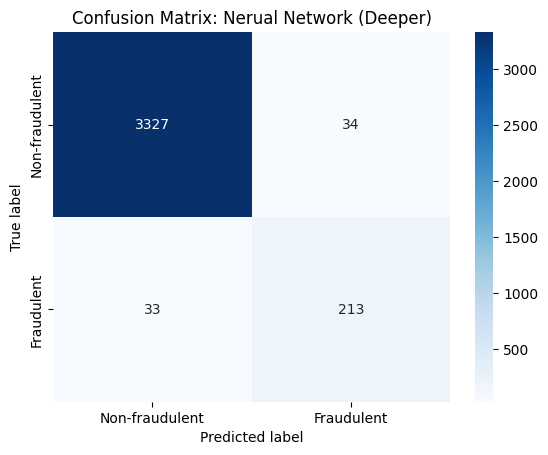

<Figure size 600x400 with 0 Axes>

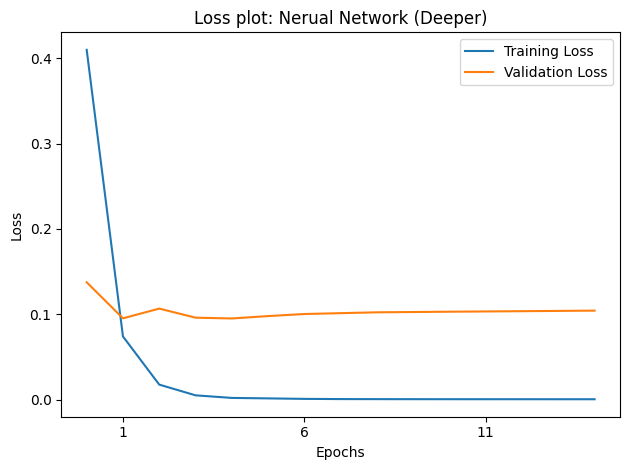

<Figure size 600x400 with 0 Axes>

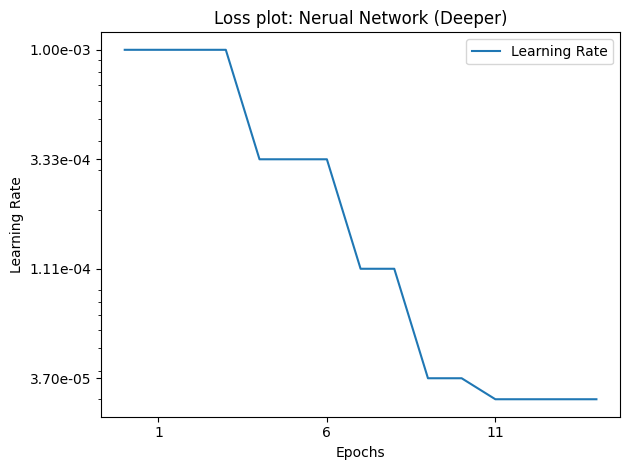

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Loss plot: Nerual Network (Deeper)'}, xlabel='Epochs', ylabel='Learning Rate'>)

In [10]:
########################################
#### Display results for each model ####
########################################

for name, metrics in trained_models.items():
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")

    y_pred_proba = metrics.predict(X_test_processed).flatten()
    y_pred = (y_pred_proba > best_thresholds[name]).astype(int)
    print(custom_classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

# Find best model by F2 score
best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = trained_models[best_model_name] 

# Predictions and confusion matrix
y_pred_proba = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report ({best_model_name}):")
print(custom_classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

plot_confusion_matrix(confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
                      f"Confusion Matrix: Nerual Network ({best_model_name})")
plot_loss(histories[best_model_name], f"Loss plot: Nerual Network ({best_model_name})")
plot_learning_rate(histories[best_model_name]['learning_rate'], f"Loss plot: Nerual Network ({best_model_name})")

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           precision    recall  f1-score  f2-score   support

Not Fraud      0.990     0.990     0.990     0.990      3361
    Fraud      0.862     0.866     0.864     0.865       246

 accuracy                                    0.981      3607



<Figure size 600x400 with 0 Axes>

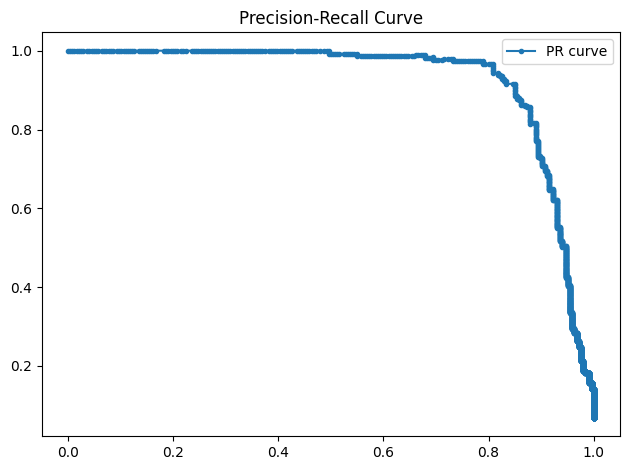

<Figure size 600x400 with 0 Axes>

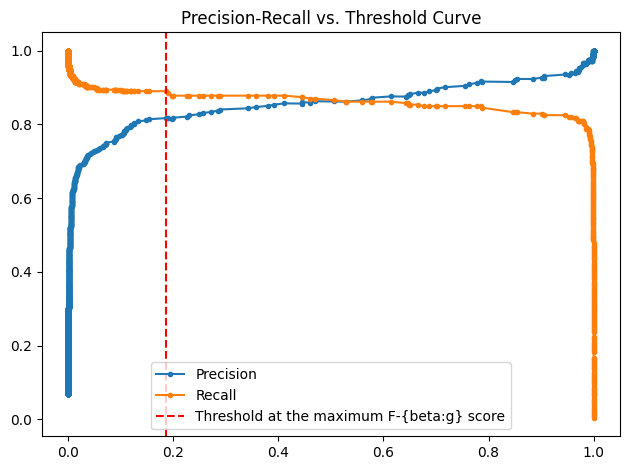

<Figure size 600x500 with 0 Axes>

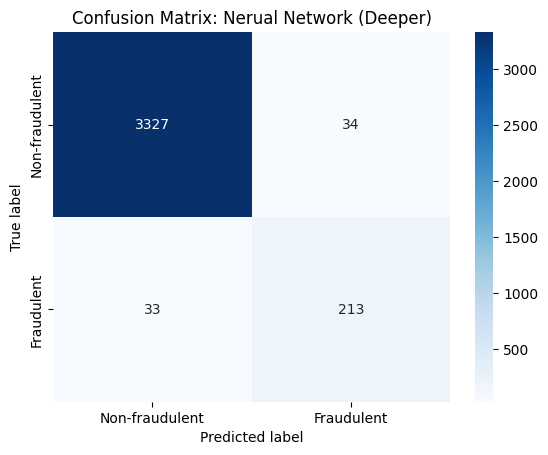

In [11]:
#################################################
#### Display detailed results for best model ####
##################################################

model = best_model
y_pred_proba = model.predict(X_test_processed).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

print(custom_classification_report(y_test, (y_pred_proba > 0.5), beta=2, digits=3))

fig, ax = plot_PR_curve(precision, recall)
fig, ax = plot_PR_threshold_curve(precision, recall, thresholds)
fig, ax = plot_confusion_matrix(
    confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
    f"Confusion Matrix: Nerual Network ({best_model_name})"
)

In [12]:
#################################
#### F1 and F2 score reports ####
#################################

max_f1_i = get_max_fscore_i(precision, recall, beta=1.0)

print('F1 score report: Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba >= 0.5).astype(int), beta=1, digits=3))

print(f'F1 score report: Using threshold of {thresholds[max_f1_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba >= thresholds[max_f1_i]).astype(int), beta=1, digits=3))

max_f2_i = get_max_fscore_i(precision, recall, beta=2.0)
print()
print('F2 score report: Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba >= 0.5).astype(int), beta=2, digits=3))

print(f'F2 score report: Using threshold of {thresholds[max_f2_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba >= thresholds[max_f2_i]).astype(int), beta=2.0, digits=3))

F1 score report: Using threshold of 0.5
           precision    recall  f1-score  f1-score   support

Not Fraud      0.990     0.990     0.990     0.990      3361
    Fraud      0.862     0.866     0.864     0.864       246

 accuracy                                    0.981      3607

F1 score report: Using threshold of 0.78
           precision    recall  f1-score  f1-score   support

Not Fraud      0.989     0.994     0.992     0.992      3361
    Fraud      0.917     0.850     0.882     0.882       246

 accuracy                                    0.984      3607


F2 score report: Using threshold of 0.5
           precision    recall  f1-score  f2-score   support

Not Fraud      0.990     0.990     0.990     0.990      3361
    Fraud      0.862     0.866     0.864     0.865       246

 accuracy                                    0.981      3607

F2 score report: Using threshold of 0.19
           precision    recall  f1-score  f2-score   support

Not Fraud      0.992     0.985    

In [13]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = f'models/nn_model_k={k}.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)